In [1]:
import pandas as pd

import konlpy
from konlpy.tag import Komoran
from konlpy.tag import Okt
from pprint import pprint
from collections import defaultdict
from collections import Counter
import warnings # 경고 알림 제거
print(konlpy.__version__)
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook # progress bar
#from konlpy.tag import Mecab #Mecab, Okt 등 형태소 분석기 불러오기,앞에서 코모란불러옴 
import numpy as np
import string # 특수문자
from gensim import corpora
from gensim import models
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) # 경고 알림이 뜨면 모두 무시

0.6.0


In [2]:
okt=Okt()

In [3]:
data = pd.read_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_review_scroll120.csv')

In [4]:
data.head(5)

,날짜,리뷰,별점,month
0,2023년 10월 14일,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...,3,2023년
1,2023년 9월 6일,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐. 버벅거리거나 로딩이 심함....,1,2023년
2,2023년 10월 17일,"핸드폰이 느려져 이상했는데, 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱...",4,2023년
3,2023년 10월 15일,"뒤로가기 ..터치 ..터치 하며 그대로 앱에서 나가는것이 아닌, ""나가시겠습니까? ...",5,2023년
4,2023년 10월 19일,"1시간에 10퍼센트 정도만 소모되던 배터리가, 토스만 사용하면 20~30퍼센트 소모...",3,2023년


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      4640 non-null   object
 1   리뷰      4640 non-null   object
 2   별점      4640 non-null   int64 
 3   month   4640 non-null   object
dtypes: int64(1), object(3)
memory usage: 145.1+ KB


In [6]:
# 결측치 확인
data.isnull().sum()

날짜       0
리뷰       0
별점       0
month    0
dtype: int64

In [7]:
# 전처리 함수

import re 

def clean_text(text):    
    
    pattern='(\[a-zA-Z0-9\_.+-\]+@\[a-zA-Z0-9]+.\[a-zA-Z0-9-.\]+)' # email제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    text = text.upper()
    
    pattern = '([ㄱ-ㅎㅏ-ㅣ])+' # 한글 자음, 모음 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'([^\w]?\d+\.?\,?\)?\d*)+') # 숫자 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='<[^>]*>' # html 태그 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='[\r|\n]' # \r,\n 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern= '[^\w\s]' # 특수기호 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'\s+')  #  이중 space 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)

#     hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자
#     text=re.sub(pattern=hangul,repl=' ',string=text) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
    
    text=text.strip()
    return text


In [8]:
data['리뷰1'] = data['리뷰'].apply(clean_text)

In [9]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1
0,2023년 10월 14일,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...,3,2023년,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...
1,2023년 9월 6일,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐. 버벅거리거나 로딩이 심함....,1,2023년,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐 버벅거리거나 로딩이 심함 동...
2,2023년 10월 17일,"핸드폰이 느려져 이상했는데, 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱...",4,2023년,핸드폰이 느려져 이상했는데 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱을...
3,2023년 10월 15일,"뒤로가기 ..터치 ..터치 하며 그대로 앱에서 나가는것이 아닌, ""나가시겠습니까? ...",5,2023년,뒤로가기 터치 터치 하며 그대로 앱에서 나가는것이 아닌 나가시겠습니까 확인 또는 뒤...
4,2023년 10월 19일,"1시간에 10퍼센트 정도만 소모되던 배터리가, 토스만 사용하면 20~30퍼센트 소모...",3,2023년,시간에 퍼센트 정도만 소모되던 배터리가 토스만 사용하면 퍼센트 소모됩니다 백그라운드...


In [10]:
##사용자 사전 추가하기
okt_userdic=Okt()

In [11]:
#불용어 생성

SW = ['카카오','페이','카카오페이','사용','카카오톡','토스','네이버','카톡','이용','가요','때문','하나','무슨','다시','어쩌',
      '해도','무슨','일시','혹시','기능','이제','하라','다른','경우','갑자기','보기','지금','이해','정말','진짜','그냥','예전',
      '아예','안나','자꾸','몇번','한번','자체','건가','워치','뱅크','은행','확인','어가','해주','어요','어서','려고','이유','도대체','아무',
      '하니','다가','계속','면서','가능','주시','려니','라면','자산','삭제','잔액','추가','까지','하나요','어디','먼저','지도','시도','더니']




In [12]:

from ckonlpy.tag import Twitter
twitter = Twitter()

c:\Users\junbong heo\AppData\Local\Programs\Python\Python311\Lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [13]:
twitter.add_dictionary('주민등록증', 'Noun')
twitter.add_dictionary('결제오류', 'Noun')
twitter.add_dictionary('카드결제', 'Noun')
twitter.add_dictionary('설치 오류', 'Noun')
twitter.add_dictionary('본인인증', 'Noun')
twitter.add_dictionary('연결상태', 'Noun')
twitter.add_dictionary('휴대폰인증', 'Noun')
twitter.add_dictionary('주식창', 'Noun')
twitter.add_dictionary('주민등록번호', 'Noun')
twitter.add_dictionary('인증번호', 'Noun')
twitter.add_dictionary('계좌연결','Noun')
twitter.add_dictionary('계좌번호','Noun')
twitter.add_dictionary('소리 알림','Noun')
twitter.add_dictionary('주식 알림','Noun')


In [14]:
import pickle

In [15]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    corpus = []
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
    for page in temp_corpus:
        corpus += page
    return corpus

def text_tokenizing(corpus, tokenizer):
    token_corpus = []

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = twitter.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = twitter.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

        
    return token_corpus

In [16]:
import ipywidgets

In [17]:
data

,날짜,리뷰,별점,month,리뷰1
0,2023년 10월 14일,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...,3,2023년,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...
1,2023년 9월 6일,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐. 버벅거리거나 로딩이 심함....,1,2023년,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐 버벅거리거나 로딩이 심함 동...
2,2023년 10월 17일,"핸드폰이 느려져 이상했는데, 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱...",4,2023년,핸드폰이 느려져 이상했는데 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱을...
3,2023년 10월 15일,"뒤로가기 ..터치 ..터치 하며 그대로 앱에서 나가는것이 아닌, ""나가시겠습니까? ...",5,2023년,뒤로가기 터치 터치 하며 그대로 앱에서 나가는것이 아닌 나가시겠습니까 확인 또는 뒤...
4,2023년 10월 19일,"1시간에 10퍼센트 정도만 소모되던 배터리가, 토스만 사용하면 20~30퍼센트 소모...",3,2023년,시간에 퍼센트 정도만 소모되던 배터리가 토스만 사용하면 퍼센트 소모됩니다 백그라운드...
...,...,...,...,...,...
4635,2019년 7월 5일,1회인증하라고 뜨는데 주소입력하고 국적 입력하면 또 주소뜨고 이런식으로 무한반복됩니...,3,2019년,회인증하라고 뜨는데 주소입력하고 국적 입력하면 또 주소뜨고 이런식으로 무한반복됩니다...
4636,2019년 9월 13일,토스 송금할려는데 업데이트 ㅇ했음에도 불구하고 업데이트 오류가 떠서 송금이 되지않습...,1,2019년,토스 송금할려는데 업데이트 했음에도 불구하고 업데이트 오류가 떠서 송금이 되지않습니...
4637,2022년 5월 24일,가계부를 안적어도되니까 너무좋았고 만보기이벤트가있어 운동도되구 두루두루 좋은점이 많...,5,2022년,가계부를 안적어도되니까 너무좋았고 만보기이벤트가있어 운동도되구 두루두루 좋은점이 많...
4638,2021년 3월 14일,정말편하고 좋은앱 다만 핸드폰 번호변경을 했음에도 불구하고 문자인증이 오지않아 애를...,3,2021년,정말편하고 좋은앱 다만 핸드폰 번호변경을 했음에도 불구하고 문자인증이 오지않아 애를...


In [18]:
data['리뷰2'] = text_tokenizing(data['리뷰1'], tokenizer="noun")

Preprocessing:   0%|          | 0/4640 [00:00<?, ?it/s]

In [19]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1,리뷰2
0,2023년 10월 14일,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...,3,2023년,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...,"[대부분, 교통카드, 시스템, 업데이트, 이후, 대기, 생기, 시간, 불만, 처리,..."
1,2023년 9월 6일,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐. 버벅거리거나 로딩이 심함....,1,2023년,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐 버벅거리거나 로딩이 심함 동...,"[동영상, 광고, 여러, 이후, 무거워, 버벅, 거리, 거나, 로딩, 동영상, 광고..."
2,2023년 10월 17일,"핸드폰이 느려져 이상했는데, 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱...",4,2023년,핸드폰이 느려져 이상했는데 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱을...,"[핸드폰, 이상, 디바이스, 케어, 리소스, 지난번, 추석, 업데이트, 이후, 친구..."
3,2023년 10월 15일,"뒤로가기 ..터치 ..터치 하며 그대로 앱에서 나가는것이 아닌, ""나가시겠습니까? ...",5,2023년,뒤로가기 터치 터치 하며 그대로 앱에서 나가는것이 아닌 나가시겠습니까 확인 또는 뒤...,"[가기, 터치, 터치, 그대로, 나가시, 가기, 가기, 부분, 시스템, 유용, 사실..."
4,2023년 10월 19일,"1시간에 10퍼센트 정도만 소모되던 배터리가, 토스만 사용하면 20~30퍼센트 소모...",3,2023년,시간에 퍼센트 정도만 소모되던 배터리가 토스만 사용하면 퍼센트 소모됩니다 백그라운드...,"[시간, 퍼센트, 정도, 소모, 배터리, 퍼센트, 소모, 라운드, 마찬가지, 알림,..."


In [20]:
# 명사 추출 후 해당 단어가 있는지 확인

[x for x in data['리뷰2'] if '토스' in x]

[]

In [21]:
data3=data[['날짜','month']].groupby('month').count().reset_index()

data3.columns=['year','count']
data3

,year,count
0,2018년,87
1,2019년,803
2,2020년,463
3,2021년,664
4,2022년,766
5,2023년,1857


In [22]:
data.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/toss_preprocessing.csv', index=None, encoding='utf-8')

In [23]:
data_2021=data[data['month']=='2021년']
data_2022=data[data['month']=='2022년']
data_2023=data[data['month']=='2023년']

data3=pd.concat([data_2021,data_2022,data_2023],axis=0)

In [24]:
data3.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/toss_preprocessing_2021_2023.csv', index=None, encoding='utf-8')

In [25]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1,리뷰2
0,2023년 10월 14일,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...,3,2023년,대부분 잘 쓰고 있지만 교통카드 시스템 업데이트 이후로 대기가 생기고 시간이 길어져...,"[대부분, 교통카드, 시스템, 업데이트, 이후, 대기, 생기, 시간, 불만, 처리,..."
1,2023년 9월 6일,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐. 버벅거리거나 로딩이 심함....,1,2023년,동영상 광고 들어가고 여러 기능이 이후로 앱이 무거워짐 버벅거리거나 로딩이 심함 동...,"[동영상, 광고, 여러, 이후, 무거워, 버벅, 거리, 거나, 로딩, 동영상, 광고..."
2,2023년 10월 17일,"핸드폰이 느려져 이상했는데, 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱...",4,2023년,핸드폰이 느려져 이상했는데 디바이스케어에서 토스 리소스가 많아 폰이 느려져 토스앱을...,"[핸드폰, 이상, 디바이스, 케어, 리소스, 지난번, 추석, 업데이트, 이후, 친구..."
3,2023년 10월 15일,"뒤로가기 ..터치 ..터치 하며 그대로 앱에서 나가는것이 아닌, ""나가시겠습니까? ...",5,2023년,뒤로가기 터치 터치 하며 그대로 앱에서 나가는것이 아닌 나가시겠습니까 확인 또는 뒤...,"[가기, 터치, 터치, 그대로, 나가시, 가기, 가기, 부분, 시스템, 유용, 사실..."
4,2023년 10월 19일,"1시간에 10퍼센트 정도만 소모되던 배터리가, 토스만 사용하면 20~30퍼센트 소모...",3,2023년,시간에 퍼센트 정도만 소모되던 배터리가 토스만 사용하면 퍼센트 소모됩니다 백그라운드...,"[시간, 퍼센트, 정도, 소모, 배터리, 퍼센트, 소모, 라운드, 마찬가지, 알림,..."


#### 빈도수

In [26]:
def flatten(l):
    flatList=[]
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList

In [27]:
data=data[data['별점']<=3]

In [28]:
data3=data3[data3['별점']<=3]

In [29]:
data.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/toss_preprocessing_neg.csv',index=False)

In [30]:
data3.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/toss_preprocessing_neg_2021_2023.csv',index=False)


In [31]:
cleaned_nouns = flatten(data['리뷰2'])

In [32]:
cleaned_nouns

['대부분',
 '교통카드',
 '시스템',
 '업데이트',
 '이후',
 '대기',
 '생기',
 '시간',
 '불만',
 '처리',
 '서버',
 '분동',
 '명대',
 '버스',
 '대기',
 '정도',
 '교통카드',
 '차라리',
 '사서',
 '정도',
 '생각',
 '고요',
 '가끔',
 '화면',
 '개선',
 '마다',
 '수도',
 '고요',
 '개선',
 '부탁',
 '드립',
 '동영상',
 '광고',
 '여러',
 '이후',
 '무거워',
 '버벅',
 '거리',
 '거나',
 '로딩',
 '동영상',
 '광고',
 '이후',
 '생각',
 '동영상',
 '광고',
 '원래',
 '혜택',
 '어플',
 '별로',
 '영상',
 '광고',
 '잔뜩',
 '점점',
 '불편',
 '제안',
 '혜택',
 '위해',
 '광고',
 '시스템',
 '입하',
 '필수',
 '불가결',
 '상황',
 '인지',
 '다만',
 '이미지',
 '형태',
 '광고',
 '기본',
 '게시',
 '동영상',
 '광고',
 '혜택',
 '방향',
 '진행',
 '고려',
 '해주시',
 '동영상',
 '광고',
 '데이터',
 '환경',
 '자동',
 '재생',
 '초뒤',
 '시간',
 '퍼센트',
 '정도',
 '소모',
 '배터리',
 '퍼센트',
 '소모',
 '라운드',
 '마찬가지',
 '알림',
 '실시간',
 '작업',
 '각하',
 '라운드',
 '해제',
 '재부팅',
 '배터리',
 '상적',
 '소모',
 '여러',
 '사람',
 '애로',
 '사항',
 '토로',
 '절약',
 '모드',
 '대책',
 '장점',
 '완성',
 '장점',
 '마저',
 '시궁창',
 '지고',
 '하루',
 '이나',
 '프리징',
 '지고',
 '터치',
 '세번',
 '터치',
 '동영상',
 '광고',
 '이후',
 '아주',
 '난리',
 '완성',
 '도나',
 '무거',
 '중구',
 '난방',
 '배치',
 '최고',
 '생각',
 

In [33]:
pd.Series(cleaned_nouns).value_counts().head(50)#상위50개 보여주기 

업데이트    926
계좌      619
광고      467
불편      389
카드      334
포인트     331
송금      316
어플      303
연결      286
오류      277
알림      269
인증      247
화면      241
문제      216
수수료     202
사람      193
혜택      192
주식      189
부터      179
등록      176
데이터     174
입력      168
결제      150
친구      146
설정      145
시간      145
부탁      142
동영상     142
이후      138
설치      137
개선      133
이상      133
생각      131
이번      130
금액      130
로그인     130
충전      126
이체      126
정보      124
짜증      124
조회      124
증권      124
가입      121
비밀번호    118
버전      116
해결      114
인증서     114
실행      114
바로      113
로딩      113
Name: count, dtype: int64

#### 특정 연도 상위빈도수 확인

In [34]:
np.unique(data['month'])

array(['2018년', '2019년', '2020년', '2021년', '2022년', '2023년'], dtype=object)

In [35]:
### 19 년도 단어 

y_19 = flatten(data['리뷰2'][data['month'] == '2019년'])
pd.Series(y_19).value_counts().head(50)

업데이트    232
계좌      196
송금      187
불편       83
오류       75
카드       72
문제       65
연결       65
입력       64
수수료      56
이체       50
어플       49
등록       48
버전       47
무료       47
화면       44
인증       43
로그인      42
조회       38
비밀번호     37
설치       37
인증서      36
이후       34
알림       34
공인       31
정보       31
사람       30
이번       29
짜증       28
해결       28
업뎃       28
아이디      28
금액       27
부탁       27
가입       27
최신       25
버튼       25
로딩       24
시간       23
생각       23
상태       23
데이터      22
부터       22
이상       22
통장       22
전화       22
문자       22
제한       22
설정       21
래서       21
Name: count, dtype: int64

In [36]:
frequency_y19=pd.DataFrame(pd.Series(y_19).value_counts().head(20)).reset_index()
frequency_y19.columns=['word','freqeuncy']
frequency_y19['year']='2019'
frequency_y19.head(5)

,word,freqeuncy,year
0,업데이트,232,2019
1,계좌,196,2019
2,송금,187,2019
3,불편,83,2019
4,오류,75,2019


In [37]:
frequency_y19.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/frequency_data/frequency_y19.csv',index=False)


In [38]:
### 20 년도 단어 

y_20 = flatten(data['리뷰2'][data['month'] == '2020년'])
pd.Series(y_20).value_counts().head(50)

업데이트    114
계좌       94
카드       68
어플       47
연결       46
등록       42
인증       39
친구       37
로딩       34
걸음       34
불편       32
광고       31
오류       31
부터       28
어도       26
수가       26
화면       26
입력       25
전화       25
가입       24
사람       24
미션       24
생각       24
부탁       23
지고       22
이상       22
금액       22
송금       22
비밀번호     22
하루       21
조회       20
설정       20
출금       20
처음       19
요즘       18
이번       17
이체       17
휴대폰      17
짜증       17
점점       17
혜택       17
수정       17
제대로      17
설치       16
문자       16
바로       16
드립       16
해결       15
결제       15
이후       15
Name: count, dtype: int64

In [39]:
frequency_y20=pd.DataFrame(pd.Series(y_20).value_counts().head(20)).reset_index()
frequency_y20.columns=['word','freqeuncy']
frequency_y20['year']='2020'
frequency_y20.head(5)

,word,freqeuncy,year
0,업데이트,114,2020
1,계좌,94,2020
2,카드,68,2020
3,어플,47,2020
4,연결,46,2020


In [40]:
frequency_y20.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/frequency_data/frequency_y20.csv',index=False)


In [41]:
### 21 년도 단어 

y_21 = flatten(data['리뷰2'][data['month'] == '2021년'])
pd.Series(y_21).value_counts().head(50)

계좌      110
업데이트     97
주식       63
어플       57
카드       50
연결       49
증권       49
불편       48
오류       43
화면       38
인증       36
입력       34
정보       32
등록       32
알림       30
실행       29
조회       28
거래       28
사람       27
비밀번호     27
설정       26
개선       26
광고       25
문제       25
부탁       24
서비스      23
인증서      22
송금       22
통장       22
가입       21
짜증       21
설치       21
수수료      21
시간       21
부터       20
이전       19
드립       19
이나       18
전화       18
데이터      18
결제       18
업뎃       18
필요       17
해결       17
인식       17
로그인      17
처럼       17
이벤트      16
신분증      16
마다       16
Name: count, dtype: int64

In [42]:
frequency_y21=pd.DataFrame(pd.Series(y_21).value_counts().head(20)).reset_index()
frequency_y21.columns=['word','freqeuncy']
frequency_y21['year']='2021'
frequency_y21.head(5)

,word,freqeuncy,year
0,계좌,110,2021
1,업데이트,97,2021
2,주식,63,2021
3,어플,57,2021
4,카드,50,2021


In [43]:
frequency_y21.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/frequency_data/frequency_y21.csv',index=False)


In [44]:
### 22 년도 단어 

y_22 = flatten(data['리뷰2'][data['month'] == '2022년'])
pd.Series(y_22).value_counts().head(50)

업데이트    164
계좌       86
불편       68
연결       58
주식       42
인증       41
어플       36
송금       34
카드       31
결제       31
오류       30
부터       29
이체       24
인증서      23
금액       23
문제       23
광고       23
알림       23
마다       22
이후       21
화면       20
데이터      20
포인트      20
증권       19
거래       19
정보       19
입력       18
바로       18
문의       18
입금       18
실행       17
동의       17
입출금      16
자동       16
신분증      16
미션       16
부탁       16
버전       16
전화       16
고요       16
채팅       16
드립       15
최신       15
이상       15
개선       15
설정       15
해외       14
업뎃       14
사라       14
조회       14
Name: count, dtype: int64

In [45]:
frequency_y22=pd.DataFrame(pd.Series(y_22).value_counts().head(20)).reset_index()
frequency_y22.columns=['word','freqeuncy']
frequency_y22['year']='2022'
frequency_y22.head(5)

,word,freqeuncy,year
0,업데이트,164,2022
1,계좌,86,2022
2,불편,68,2022
3,연결,58,2022
4,주식,42,2022


In [46]:
frequency_y22.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/frequency_data/frequency_y22.csv',index=False)


In [47]:
### 23 년도 단어 

y_23 = flatten(data['리뷰2'][data['month'] == '2023년'])
pd.Series(y_23).value_counts().head(50)

광고      362
업데이트    307
포인트     296
알림      165
불편      153
혜택      149
동영상     137
충전      110
어플      107
데이터     107
카드      107
화면      106
수수료     104
계좌      102
라이브      98
사람       98
오류       91
교통카드     90
문제       88
점검       85
주식       82
친구       78
인증       76
부터       76
시간       75
결제       66
연결       62
설정       61
개선       60
점점       59
이상       58
자동       58
재생       57
이번       57
고객       57
생각       56
적립       53
지고       53
이후       52
부탁       50
접속       50
정도       50
하루       49
로그인      48
바로       48
증권       48
이나       48
고요       48
짜증       48
출금       47
Name: count, dtype: int64

In [48]:
frequency_y23=pd.DataFrame(pd.Series(y_23).value_counts().head(20)).reset_index()
frequency_y23.columns=['word','freqeuncy']
frequency_y23['year']='2023'
frequency_y23.head(5)

,word,freqeuncy,year
0,광고,362,2023
1,업데이트,307,2023
2,포인트,296,2023
3,알림,165,2023
4,불편,153,2023


In [49]:
frequency_y23.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/toss_datafile/frequency_data/frequency_y23.csv',index=False)


In [50]:
def __array__(self):
    """Convert to numpy array.
    Returns 
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()
def to_array(self):
    return np.array(self.to_image())

In [51]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
#윈도우용 font_path = 'C:/Windows/Fonts/malgun.ttf'
font_path='C:/Windows/Fonts/malgun.ttf'
wordcloud=WordCloud(font_path=font_path, width=800, height=800, 
                    background_color="white", colormap="Set2")

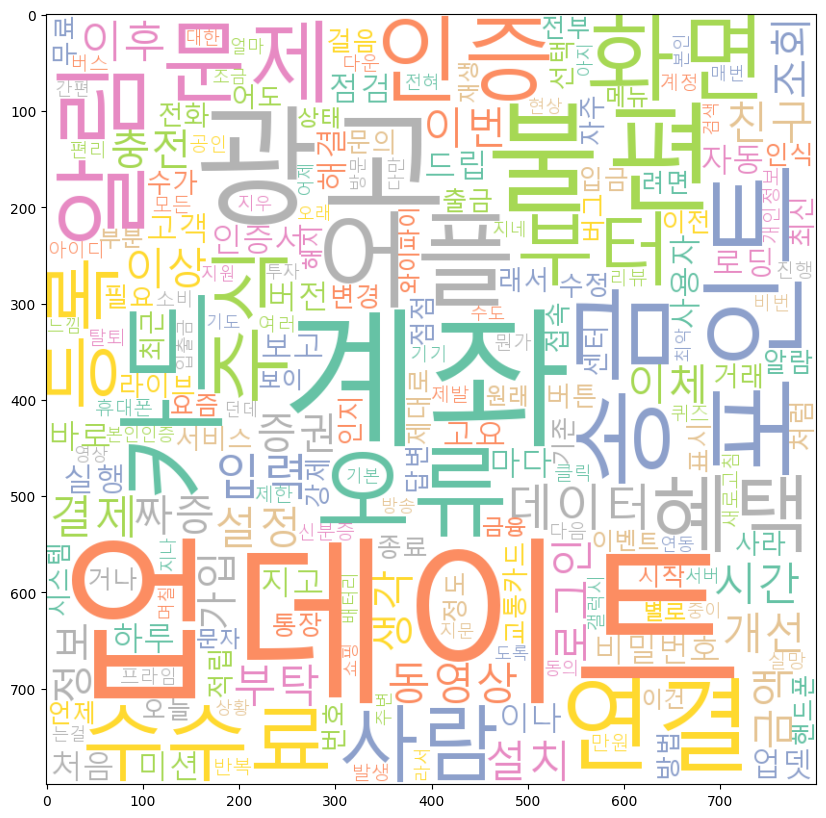

In [53]:
#### 2019년~~2023년

wordcloud=wordcloud.generate_from_frequencies(Counter(cleaned_nouns))
array=wordcloud.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

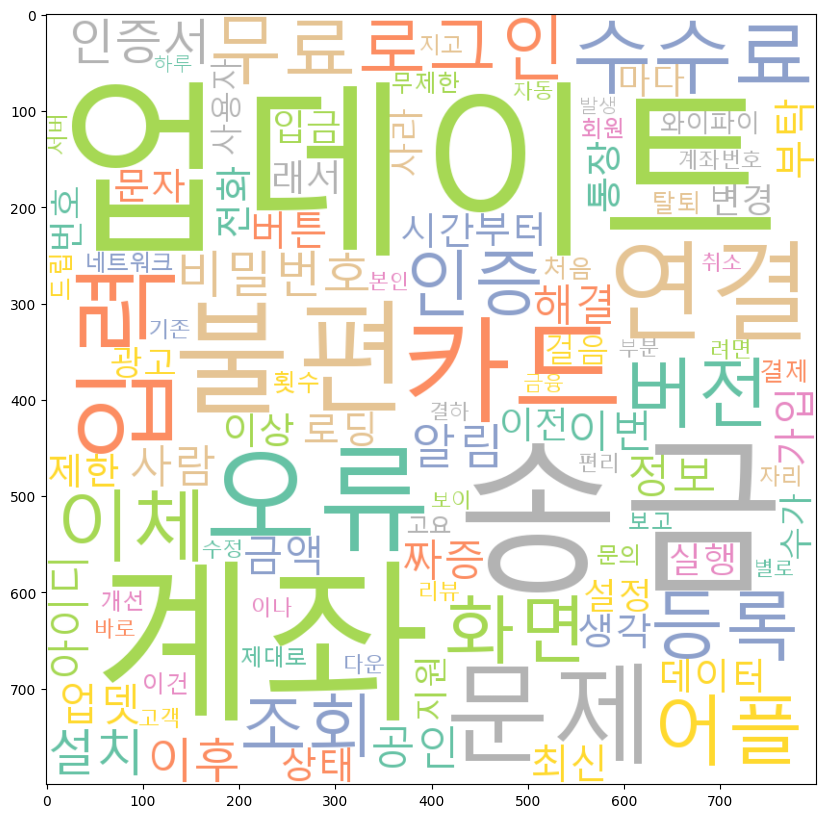

In [54]:
#### 2019년

df_words2019=Counter(y_19)
wordcloud_19=wordcloud.generate_from_frequencies(dict(df_words2019.most_common(100)))
array=wordcloud_19.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

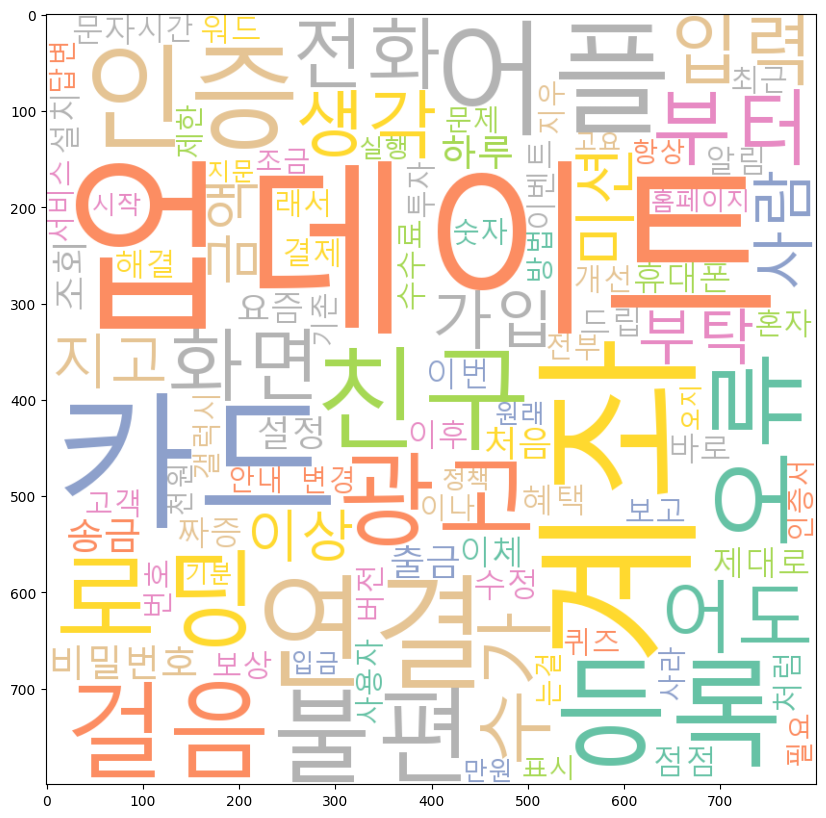

In [58]:
#### 2020년

df_words2020=Counter(y_20)
wordcloud_20=wordcloud.generate_from_frequencies(dict(df_words2020.most_common(100)))
array=wordcloud_20.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

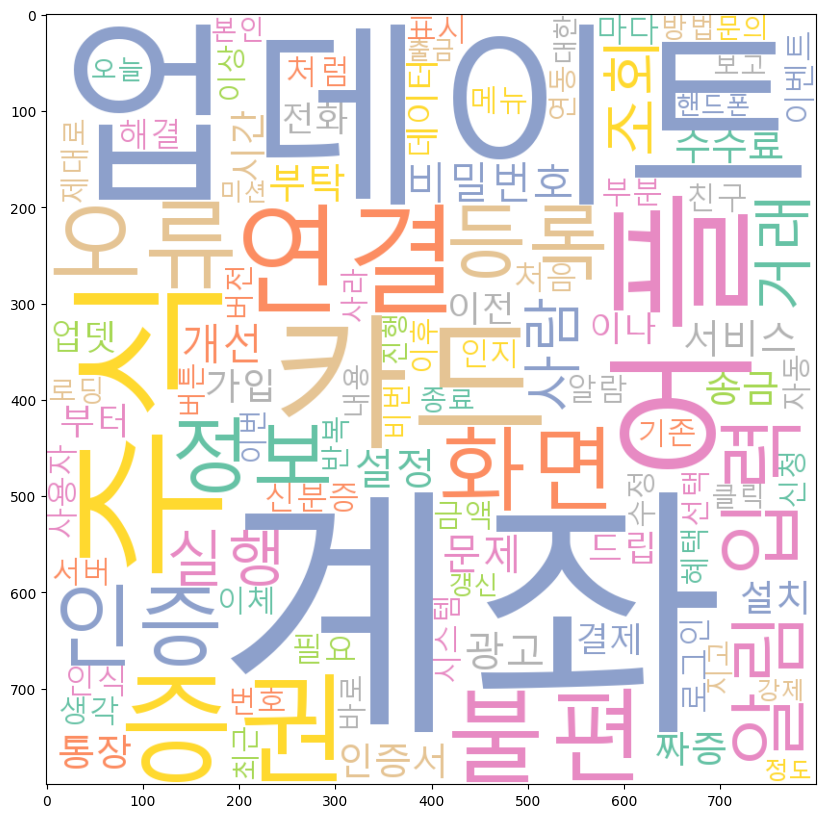

In [57]:
#### 2021년

df_words2021 =Counter(y_21)
wordcloud_21=wordcloud.generate_from_frequencies(dict(df_words2021.most_common(100)))
array=wordcloud_21.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

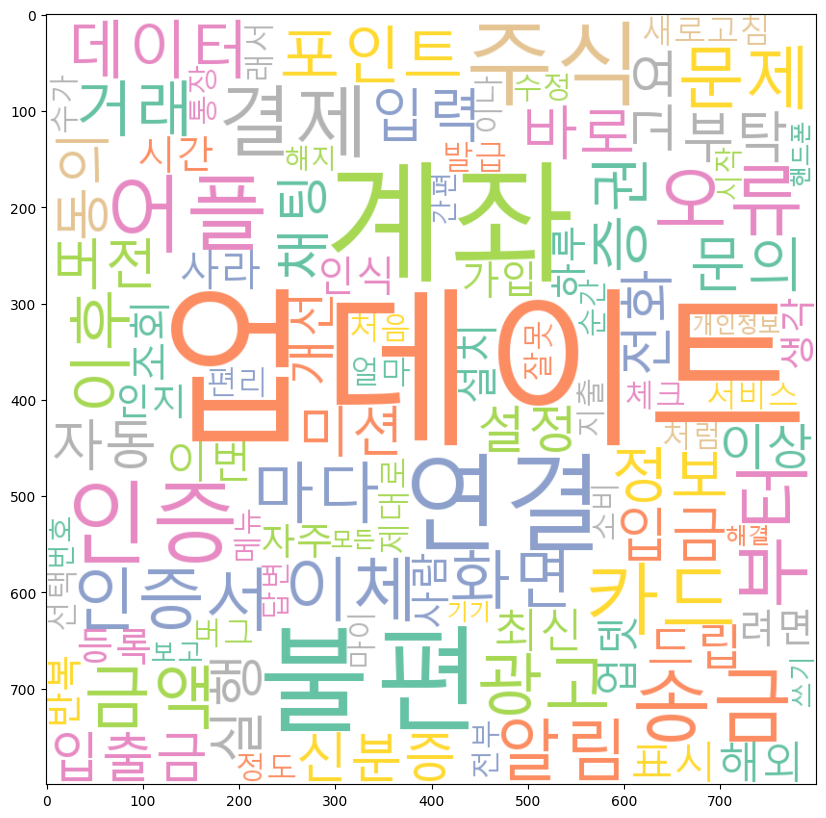

In [59]:
#### 2022년

df_words2022 =Counter(y_22)
wordcloud_22=wordcloud.generate_from_frequencies(dict(df_words2022.most_common(100)))
array=wordcloud_22.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

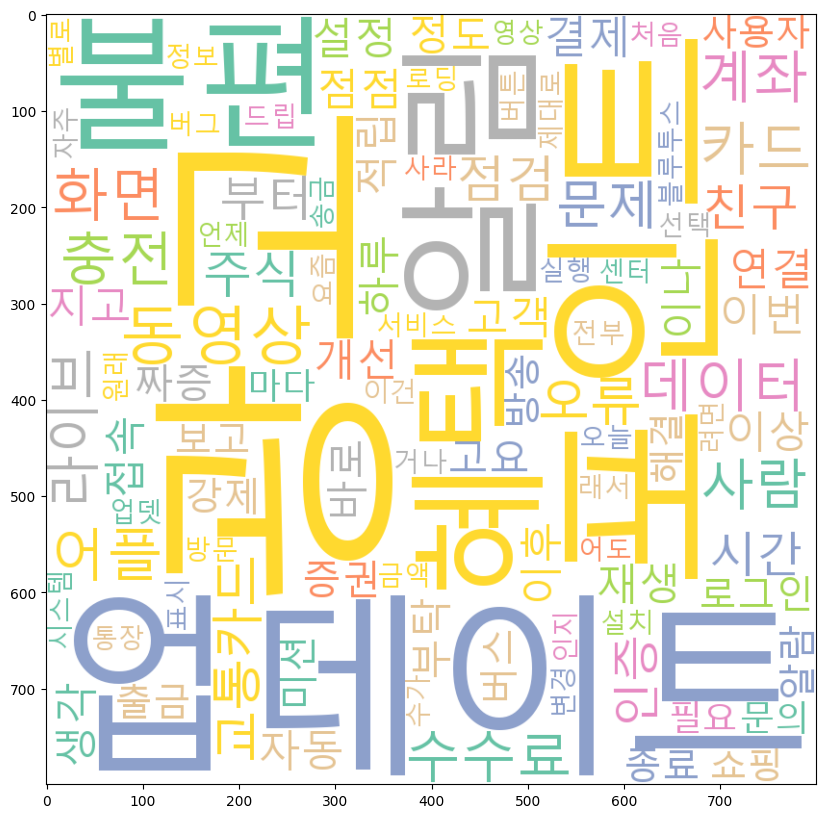

In [60]:
#### 2023년

df_words2023 =Counter(y_23)
wordcloud_23=wordcloud.generate_from_frequencies(dict(df_words2023.most_common(100)))
array=wordcloud_23.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()